In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import tensorflow as tf
from IPython.display import HTML

In [2]:
from simulatorMultiDim import Simulator
from geometry import geo2d_33conv, geo3d_13conv
from renderer import Renderer

GPUs found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2 dimensions

In [3]:
m,n = 200,220

mask = np.ones((m,n, 1), dtype=np.float32)
rad = 12
for i in range(rad*2) :
    for j in range(rad*2) :
        di = i-rad
        dj = j-rad
        if di*di + dj*dj < rad*rad :
            mask[m//2+i-rad,n//2+j-rad] = 0

force_j_min = n*4//10
force_j_max = n*6//10
    
def force(w):
    m,n = w.shape[:2]
    f = np.zeros((m,n,2))
    f[5:m//2,force_j_min:force_j_max,0] = 1 - w[5:m//2,force_j_min:force_j_max,0]
    f += np.random.normal(size=(m,n,2))/3
    return tf.constant(f, dtype=tf.float32)

sim = Simulator((m,n), 1, 0.01, force, geo2d_33conv(m,n), mask)

0
500
CPU times: user 32.2 s, sys: 1.38 s, total: 33.6 s
Wall time: 24.8 s


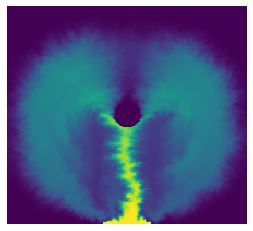

In [4]:
%%time

x = np.zeros((m,n))
def take_scalar(a,indices_i, indices_j) :
    m,n = a.shape[:2]
    full_idices = n*indices_i + indices_j
    reshaped = a.reshape(m*n)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n)

def update_scalar(s,w,dt) :
    m,n = w.shape[:2]
    indices = np.indices((m,n)).swapaxes(0,2).swapaxes(0,1) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,0] = np.clip(indices_floor[:,:,0], 0, m-1)
    indices_ceil[:,:,0] = np.clip(indices_ceil[:,:,0], 0, m-1)
    indices_floor[:,:,1] = np.clip(indices_floor[:,:,1], 0, n-1)
    indices_ceil[:,:,1] = np.clip(indices_ceil[:,:,1], 0, n-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,2

    res = np.zeros((m,n))
    for i in range(2) :
        for j in range(2) :
            res += np.reshape(frac[i][:,:,0]*frac[j][:,:,1], (m,n)) * take_scalar(x, indices[i][:,:,0], indices[j][:,:,1])
    res = res*1
    res[0:2,force_j_min:force_j_max] = 1
    return res

fig = plt.figure()
ims = []
for i in range(1000) :
    dt=1
    sim.time_step(dt)
    x = update_scalar(x,sim.w,dt)
    if not i % 500 :
        print(i)
    if not i % 3 :
        plt.axis('off')
        ims.append([plt.imshow(x[::-1,:], animated=True)])

In [5]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())

## 3 Dimensions

In [6]:
def force_3d(w):
    m,n,p = w.shape[:3]
    f = np.zeros((m,n,p,3))
    f[17:22,:,17:22,1] = 1 - w[17:22,:,17:22,1]
    f += np.random.normal(size=(m,n,p,3))/10
    return tf.constant(f, tf.float32)

In [7]:
m,n,p = 40,41,42
sim = Simulator((m,n,p),1,0.01, force_3d, geo3d_13conv(m,n,p))

0
50
100
150
200
CPU times: user 1min 50s, sys: 5.52 s, total: 1min 56s
Wall time: 27.9 s


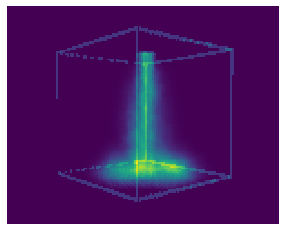

In [8]:
%%time

x = np.zeros((m,n,p))

def take_scalar(a,indices_i, indices_j, indices_k) :
    m,n,p = a.shape[:3]
    full_idices = p*(n*indices_i + indices_j) + indices_k
    reshaped = a.reshape(m*n*p)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n,p)

def update_scalar(s,w,dt) :
    m,n,p = w.shape[:3]
    indices = np.indices((m,n,p)).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,:,0] = np.clip(indices_floor[:,:,:,0], 0, m-1)
    indices_ceil[:,:,:,0] = np.clip(indices_ceil[:,:,:,0], 0, m-1)
    indices_floor[:,:,:,1] = np.clip(indices_floor[:,:,:,1], 0, n-1)
    indices_ceil[:,:,:,1] = np.clip(indices_ceil[:,:,:,1], 0, n-1)
    indices_floor[:,:,:,2] = np.clip(indices_floor[:,:,:,2], 0, p-1)
    indices_ceil[:,:,:,2] = np.clip(indices_ceil[:,:,:,2], 0, p-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,p,3

    res = np.zeros((m,n,p))
    for i in range(2) :
        for j in range(2) :
            for k in range(2) :
                res += np.reshape(frac[i][:,:,:,0]*frac[j][:,:,:,1]*frac[k][:,:,:,2], (m,n,p)) * take_scalar(x, indices[i][:,:,:,0], indices[j][:,:,:,1], indices[k][:,:,:,2])
    res = res*1
    res[17:22,1,17:22] = 1
    return res

camera_pos = np.array([-m,n/2,p/2])

fig = plt.figure()
ims = []

renderer = Renderer(120,150, 170)

center = (np.array([m,n,p])-1)/2
t = 0
for i in range(230) :
    dt=1
    sim.time_step(dt)
    x = update_scalar(x,sim.w,dt)
    x_proj = np.amax(x,-1)
    if not i % 50 :
        print(i)
    if not i % 1 :
        t+=0.01
        camera_pos = center +100*np.array([-np.cos(t),0,-np.sin(t)])
        plt.axis('off')
        res = renderer(x, camera_pos)
        ims.append([plt.imshow(res, animated=True)])

In [9]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())